# Setting up pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz (link outdated)
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
# sparkmaster = "spark://itd353-ext:7077" # change this according to your machine domain name, check out https://localhost:8080
# sparkSession = SparkSession.builder.master(sparkmaster).appName("Fraud Detection").getOrCreate()
sparkSession = SparkSession.builder\
               .master("local")\
               .appName("Colab")\
               .config('spark.ui.port', '4050')\
               .getOrCreate()

sparkSession

# Setting up libaries

In [ ]:
!pip install -q handyspark

     |████████████████████████████████| 212.4 MB 63 kB/s 
     |████████████████████████████████| 198 kB 52.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from google.colab import drive, files
from handyspark import BinaryClassificationMetrics

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.pipeline import PipelineModel

# Source codes

Confusion Matrix Plotting

In [ ]:
# Source code for plotting confusion matrix is based on `plot_confusion_matrix`
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html#decision-tree-classification
# import matplotlib.pyplot as plt
# import numpy as np
# import itertools

def plot_confusion_matrix(cm, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)

  # Configure plot
  classes = ['Fraud', 'No Fraud']
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cm.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  # Display images
  image = fig

  # Show plot
  #fig = plt.show()

  # Save plot
  #fig.savefig("confusion-matrix.png")

  # Display Plot
  display(image)

  # Close Plot
  plt.close(fig)

# Importing Data

In [ ]:
# from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
dataset_path = '/content/drive/MyDrive/NYP ITD354'
dataset_filename = 'PS_20174392719_1491204439457_log.csv'
# hadoopmaster = "hdfs://127.0.0.1:9000"

transactions = sparkSession \
               .read.option("header", "true") \
               .option("delimiter", ",") \
               .option("inferSchema", "true") \
               .csv(os.path.join(dataset_path, dataset_filename)) #.csv(hadoopmaster + "/data/Covid-19-SG.csv")

# EDA

In [ ]:
transactions.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [ ]:
transactions.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [ ]:
transactions.count()

6362620

In [ ]:
transactions.groupBy('type', 'isFraud').count().show()

+--------+-------+-------+
|    type|isFraud|  count|
+--------+-------+-------+
| PAYMENT|      0|2151495|
|CASH_OUT|      0|2233384|
|TRANSFER|      1|   4097|
|CASH_OUT|      1|   4116|
|   DEBIT|      0|  41432|
| CASH_IN|      0|1399284|
|TRANSFER|      0| 528812|
+--------+-------+-------+



In [ ]:
query = '''
SELECT
  type,
  SUM(isFraud) AS numFraud,
  ROUND(SUM(amount * isFraud) / 1000000) AS fraudMil,
  COUNT(1) AS totalTransactions,
  ROUND(SUM(amount / 1000000)) AS transactionsMil
FROM __THIS__
GROUP BY type
ORDER BY numFraud, totalTransactions DESC
'''
sqlTrans = SQLTransformer(statement=query)
sqlTrans.transform(transactions).show()

+--------+--------+--------+-----------------+---------------+
|    type|numFraud|fraudMil|totalTransactions|transactionsMil|
+--------+--------+--------+-----------------+---------------+
| PAYMENT|       0|     0.0|          2151495|        28093.0|
| CASH_IN|       0|     0.0|          1399284|       236367.0|
|   DEBIT|       0|     0.0|            41432|          227.0|
|TRANSFER|    4097|  6067.0|           532909|       485292.0|
|CASH_OUT|    4116|  5989.0|          2237500|       394413.0|
+--------+--------+--------+-----------------+---------------+



In [ ]:
query = '''
SELECT type, COUNT(1) AS numOrigMerchant
FROM __THIS__
WHERE nameOrig LIKE 'M%'
GROUP BY type
'''
sqlTrans = SQLTransformer(statement=query)
sqlTrans.transform(transactions).show()

query = '''
SELECT type, COUNT(nameDest LIKE 'M%') AS numDestMerchant
FROM __THIS__
WHERE nameDest LIKE 'M%'
GROUP BY type
'''
sqlTrans = SQLTransformer(statement=query)
sqlTrans.transform(transactions).show()

+----+---------------+
|type|numOrigMerchant|
+----+---------------+
+----+---------------+

+-------+---------------+
|   type|numDestMerchant|
+-------+---------------+
|PAYMENT|        2151495|
+-------+---------------+



# Preprocessing

## Creating features for difference in balance

In [ ]:
transactions = transactions\
               .withColumn('origDiff', transactions['newbalanceOrig'] - transactions['oldbalanceOrg']) \
               .withColumn('destDiff', transactions['newbalanceDest'] - transactions['oldbalanceDest'])

transactions.show(5)

## Encoding of 'nameOrig' and 'nameDest' (skipped)

In [ ]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import IntegerType

def is_merchant(name):
  return 1 if name[0]=='M' else 0

is_merchant_udf = udf(is_merchant, IntegerType())

transactions = transactions \
               .withColumn('isOrigMerchant', is_merchant_udf(transactions['nameOrig'])) \
               .withColumn('isDestMerchant', is_merchant_udf(transactions['nameDest']))

transactions.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+---------+----------------+----------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|          Orig_diff|Dest_diff|is_Orig_merchant|is_Dest_merchant|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+---------+----------------+----------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| -9839.640000000014|      0.0|               0|               1|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|-1864.2799999999988|      0.0|               0|               1|
|   1|TRANSFER|   181.0|C

## Train-Test Split

Split by time-step instead of shuffling and drawing random samples as the transactions are may be related to one another with respect to time.

In [ ]:
train = transactions.filter(transactions['step'] <= 335)
test = transactions.filter(transactions['step'] > 335)

# Cache the training and test datasets
train.cache()
test.cache()

print('train size:\t', train.count())
print('test size:\t', test.count())

train size:	 4781843
test size:	 1580777


## Balancing classes on train set (skipped)

Undersampling of non-fraud cases\
Skipped as undersampling resulted in worse results from too much information lost.

In [ ]:
# Reset the DataFrames for no fraud (`dfn`) and fraud (`dfy`)
dfn = train.filter(train['isFraud'] == 0)
dfy = train.filter(train['isFraud'] == 1)

# Calculate summary metrics
N = train.count()
y = dfy.count()
p = y/N

# Create a more balanced training dataset
train = dfn.sample(False, p, seed = 1234).union(dfy)
train = train.cache()

# Print out metrics
print("Total count: %s, Fraud cases count: %s, Proportion of fraud cases: %s" % (N, y, p))
print("Balanced training dataset count: %s" % train.count())

Total count: 4781843, Fraud cases count: 3749, Proportion of fraud cases: 0.000784007337756593
Balanced training dataset count: 7379


## Common pipeline stages

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol = "type", outputCol = "typeIdx")

# One-hot encoding
encoder = OneHotEncoder(inputCol = "typeIdx", outputCol = "typeOhe")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
features_names = [
  "typeOhe", "amount", #"is_Dest_merchant",
  "oldbalanceOrg", "newbalanceOrig", "origDiff",
  "oldbalanceDest", "newbalanceDest", "destDiff",
]
assembler = VectorAssembler(inputCols = features_names, outputCol = "features")

In [ ]:
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use BinaryClassificationEvaluator to evaluate our model
evaluatorPR = BinaryClassificationEvaluator(labelCol = "isFraud", rawPredictionCol = "probability", metricName = "areaUnderPR")
evaluatorAUC = BinaryClassificationEvaluator(labelCol = "isFraud", rawPredictionCol = "probability", metricName = "areaUnderROC")

# Modeling

## Decision Tree

### Cross Validation

In [ ]:
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features", seed=1234)

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
            .addGrid(dt.maxDepth, [5, 10, 12, 15]) \
            .addGrid(dt.maxBins, [16, 32, 64, 128, 256]) \
            .build()

# Build out the cross validation
crossval = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorPR,
                          numFolds = 3)

pipelineCV = Pipeline(stages=[indexer, encoder, assembler, crossval])

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel = pipelineCV.fit(train)

In [ ]:
# Build the best model (training and test datasets)
train_pred = cvModel.transform(train)
test_pred = cvModel.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.8419168653872782
AUC train: 0.9985495903488629
PR test: 0.8816996883732031
AUC test: 0.9912325718880082


In [ ]:
# CV parameters
cv_MaxDepth = cvModel.stages[-1].bestModel.getMaxDepth()
cv_MaxBins = cvModel.stages[-1].bestModel.getMaxBins()

print('max depth:', cv_MaxDepth)
print('max bins:', cv_MaxBins)

max depth: 12
max bins: 128


### Final Model

In [ ]:
# from pyspark.ml.classification import DecisionTreeClassifier

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features", seed=1234,
                            maxDepth=12, maxBins=128)

# Create our pipeline stages
pipeline = Pipeline(stages=[indexer, encoder, assembler, dt])

# Train the Decision Tree model
dt_model = pipeline.fit(train)

In [ ]:
# Build the best model (training and test datasets)
train_pred = dt_model.transform(train)
test_pred = dt_model.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.8419168653872782
AUC train: 0.9985495903488629
PR test: 0.8816996883732031
AUC test: 0.9912325718880082


Visualisation

In [ ]:
# !pip install -q handyspark

     |████████████████████████████████| 212.4 MB 68 kB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 


Area under ROC Curve: 0.9912
Area under PR Curve: 0.8817


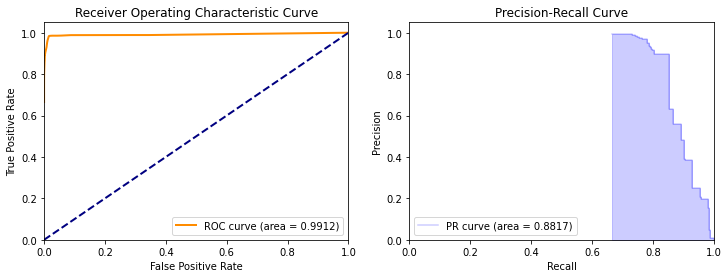

In [ ]:
# from handyspark import BinaryClassificationMetrics
# import matplotlib.pyplot as plt

test_pred = dt_model.transform(test)

bcm = BinaryClassificationMetrics(test_pred, scoreCol='probability', labelCol='isFraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

Confusion Matrix

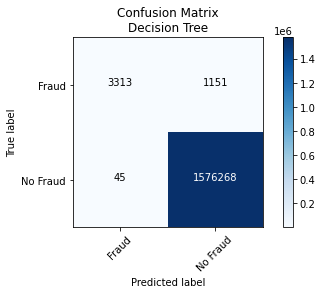

In [ ]:
test_pred = dt_model.transform(test)

yy = test_pred.filter(test_pred['isFraud']==1).filter(test_pred['prediction']==1).count()
yn = test_pred.filter(test_pred['isFraud']==1).filter(test_pred['prediction']==0).count()
ny = test_pred.filter(test_pred['isFraud']==0).filter(test_pred['prediction']==1).count()
nn = test_pred.filter(test_pred['isFraud']==0).filter(test_pred['prediction']==0).count()

cm = np.array([[yy, yn], [ny, nn]])
plot_confusion_matrix(cm, "Confusion Matrix\nDecision Tree")

Threshold Adjustment\
Note that this should be done on dev set and not test set

In [ ]:
bcm.getMetricsByThreshold().filter('fpr between 0.05 and 0.2').toPandas()
bcm.getMetricsByThreshold().filter('recall between 0.8 and 0.85').toPandas()
bcm.getMetricsByThreshold().filter('precision between 0.9 and 0.95').toPandas()

,threshold,fpr,recall,precision
0,0.159314,0.000117,0.782482,0.949701
1,0.145570,0.000148,0.787634,0.937600
2,0.142857,0.000150,0.788978,0.936951
3,0.109375,0.000164,0.791891,0.931980
4,0.104478,0.000176,0.794355,0.927544
5,0.071429,0.000199,0.795475,0.918996
6,0.068493,0.000211,0.797043,0.914653
7,0.062780,0.000248,0.802643,0.901610


Decision Tree Rules or Plot (TBC...)

### Saving

Save model to current lab session. Files will be deleted once session terminates.

In [ ]:
dt_model.save('decision_tree')

Zip folder

In [ ]:
!zip -r -q decision_tree decision_tree

Save zipped folder to ITD354 shared folder in google drive

In [ ]:
cp 'decision_tree.zip' '/content/drive/MyDrive/NYP ITD354'

Download zipped folder to personal device

In [ ]:
# from google.colab import files
files.download("decision_tree.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Loading

Upload zippped file to current lab session

In [ ]:
# from google.colab import files
files.upload()

Copy folder from google drive

In [ ]:
cp '/content/drive/MyDrive/NYP ITD354/decision_tree.zip' '/content'

Unzip folder in current lab session

In [ ]:
!unzip decision_tree.zip

Load model from current lab session

In [ ]:
# from pyspark.ml.pipeline import PipelineModel
dt_model = PipelineModel.load('decision_tree/')

## Random Forests

### Cross Validation

In [ ]:
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Using the RandomForest classifier model
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", seed=1234)

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [15, 20, 25, 30]) \
            .addGrid(rf.subsamplingRate, [1]) \
            .addGrid(rf.maxDepth, [12]) \
            .addGrid(rf.maxBins, [128]) \
            .build()

# Build out the cross validation
crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorPR,
                          numFolds = 3)

pipelineCV = Pipeline(stages=[indexer, encoder, assembler, crossval])

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel = pipelineCV.fit(train)

In [ ]:
# Build the best model (training and test datasets)
train_pred = cvModel.transform(train)
test_pred = cvModel.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.8761108402753527
AUC train: 0.9989280406554017
PR test: 0.9167609615884521
AUC test: 0.999332353179284


In [ ]:
# CV parameters
cv_NumTrees = cvModel.stages[-1].bestModel.getNumTrees
cv_SubsamplingRate = cvModel.stages[-1].bestModel.getSubsamplingRate()
cv_MaxDepth = cvModel.stages[-1].bestModel.getMaxDepth()
cv_MaxBins = cvModel.stages[-1].bestModel.getMaxBins()

print('num trees:', cv_NumTrees)
print('subsampling rate:', cv_SubsamplingRate)
print('max depth:', cv_MaxDepth)
print('max bins:', cv_MaxBins)

num trees: 25
subsampling rate: 1.0
max depth: 12
max bins: 128


### Final Model

In [ ]:
# from pyspark.ml.classification import RandomForestClassifier

# Using the RandomForest classifier model
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", seed=1234,
                            numTrees=30, subsamplingRate=1, maxDepth=12, maxBins=128)

# Create our pipeline stages
pipeline = Pipeline(stages=[indexer, encoder, assembler, rf])

# Train the Random Forest model
rf_model = pipeline.fit(train)

In [ ]:
# Build the best model (training and test datasets)
train_pred = rf_model.transform(train)
test_pred = rf_model.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.8823783382627436
AUC train: 0.9989251364638136
PR test: 0.9202127952408582
AUC test: 0.9994104156270684


Visualisation

In [ ]:
# !pip install -q handyspark

     |████████████████████████████████| 212.4 MB 70 kB/s 
     |████████████████████████████████| 198 kB 60.8 MB/s 


Area under ROC Curve: 0.9994
Area under PR Curve: 0.9202


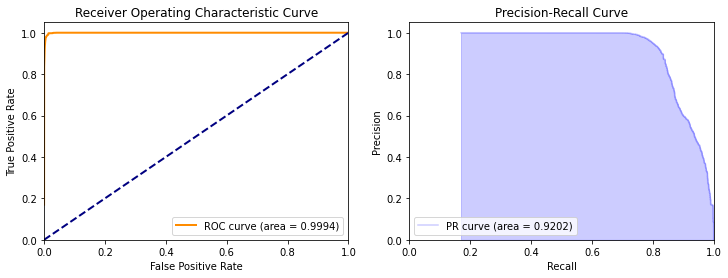

In [ ]:
# from handyspark import BinaryClassificationMetrics
# import matplotlib.pyplot as plt

test_pred = rf_model.transform(test)

bcm = BinaryClassificationMetrics(test_pred, scoreCol='probability', labelCol='isFraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

Confusion Matrix

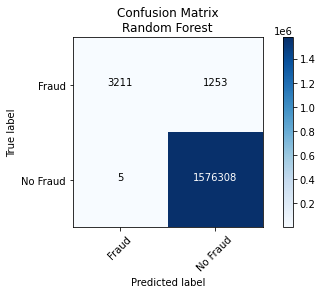

In [ ]:
test_pred = rf_model.transform(test)

yy = test_pred.filter(test_pred['isFraud']==1).filter(test_pred['prediction']==1).count()
yn = test_pred.filter(test_pred['isFraud']==1).filter(test_pred['prediction']==0).count()
ny = test_pred.filter(test_pred['isFraud']==0).filter(test_pred['prediction']==1).count()
nn = test_pred.filter(test_pred['isFraud']==0).filter(test_pred['prediction']==0).count()

cm = np.array([[yy, yn], [ny, nn]])
plot_confusion_matrix(cm, "Confusion Matrix\nRandom Forest")

Threshold Adjustment\
Note that this should be done on dev set and not test set

In [ ]:
bcm.getMetricsByThreshold().filter('fpr between 0 and 0.2').toPandas()
bcm.getMetricsByThreshold().filter('recall between 0.5 and 0.8').toPandas()
bcm.getMetricsByThreshold().filter('precision between 0.5 and 0.8').toPandas()

### Saving

Save model to current lab session. Files will be deleted once session terminates.

In [ ]:
rf_model.save('random_forest')

Zip folder

In [ ]:
!zip -r -q random_forest random_forest

Save zipped folder to ITD354 shared folder in google drive

In [ ]:
cp 'random_forest.zip' '/content/drive/MyDrive/NYP ITD354'

Download zipped folder to personal device

In [ ]:
# from google.colab import files
files.download("random_forest.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Loading

Upload zippped file to current lab session

In [ ]:
# from google.colab import files
files.upload()

Copy folder from google drive

In [ ]:
cp '/content/drive/MyDrive/NYP ITD354/random_forest.zip' '/content'

Unzip folder in current lab session

In [ ]:
!unzip random_forest.zip

Load model from current lab session

In [ ]:
# from pyspark.ml.pipeline import PipelineModel
rf_model = PipelineModel.load('random_forest/')

## MLP

In [ ]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MaxAbsScaler

# Encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol = "type", outputCol = "type_idx")

# One-hot encoding
encoder = OneHotEncoder(inputCol="type_idx", outputCol="type_ohe")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
cts_features_names = [
  "amount",
  "oldbalanceOrg", "newbalanceOrig", "Orig_diff",
  "oldbalanceDest", "newbalanceDest", "Dest_diff",
]
cts_assembler = VectorAssembler(inputCols = cts_features_names, outputCol = "unscaledFeatures")

scaler = StandardScaler(inputCol = "unscaledFeatures", outputCol = "scaledFeatures",
                        withMean=True, withStd=True)
# scaler = MaxAbsScaler(inputCol = "unscaledFeatures", outputCol = "scaledFeatures")

final_assembler = VectorAssembler(inputCols = ["scaledFeatures", "type_ohe"], outputCol = "features")

### Cross Validation

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Using the RandomForest classifier model
mlp = MultilayerPerceptronClassifier(labelCol="isFraud", featuresCol="features", seed=1234)

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
            .addGrid(mlp.layers, [[11, 5, 2], [11, 8, 5, 2]]) \
            .addGrid(mlp.blockSize, [32, 64, 128]) \
            .build()

# Build out the cross validation
crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorPR,
                          numFolds = 3)

pipelineCV = Pipeline(stages=[indexer, encoder, cts_assembler, scaler, final_assembler, crossval])

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel = pipelineCV.fit(train)

In [ ]:
# Build the best model (training and test datasets)
train_pred = cvModel.transform(train)
test_pred = cvModel.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

In [ ]:
# CV parameters
cv_Layers = cvModel.stages[-1].bestModel.getLayers()
cv_BlockSize = cvModel.stages[-1].bestModel.getBlockSize()

print('layers:', cv_Layers)
print('block size:', cv_BlockSize)

### Final Model

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Using the RandomForest classifier model
mlp = MultilayerPerceptronClassifier(labelCol="isFraud", featuresCol="features", seed=1234,
                                     layers=[11, 5, 2], blockSize=128, stepSize=0.3)

# Create our pipeline stages
pipeline = Pipeline(stages=[indexer, encoder, cts_assembler, scaler, final_assembler, mlp])

# Train the Random Forest model
mlp_model = pipeline.fit(train)

In [ ]:
# Build the best model (training and test datasets)
train_pred = mlp_model.transform(train)
test_pred = mlp_model.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.5715960737298619
AUC train: 0.9946399914205764
PR test: 0.904302077033853
AUC test: 0.9929031995638913


Visualisation

In [ ]:
# !pip install -q handyspark

Area under ROC Curve: 0.9929
Area under PR Curve: 0.9043


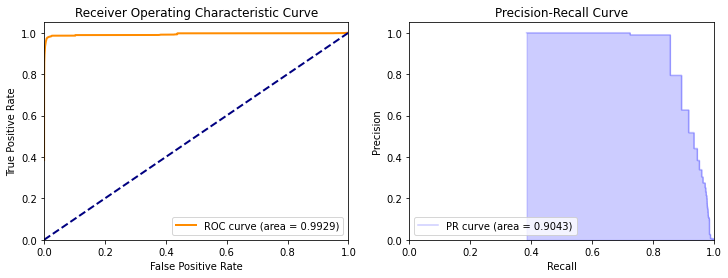

In [ ]:
# from handyspark import BinaryClassificationMetrics
# import matplotlib.pyplot as plt

test_pred = mlp_model.transform(test)

bcm = BinaryClassificationMetrics(test_pred, scoreCol='probability', labelCol='isFraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

Confusion Matrix

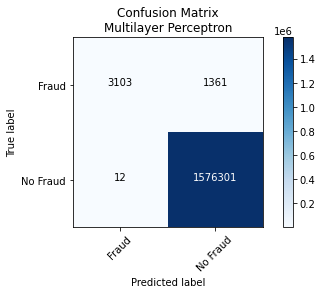

In [ ]:
test_pred = mlp_model.transform(test)

yy = test_pred.filter(test_pred['isFraud']==1).filter(test_pred['prediction']==1).count()
yn = test_pred.filter(test_pred['isFraud']==1).filter(test_pred['prediction']==0).count()
ny = test_pred.filter(test_pred['isFraud']==0).filter(test_pred['prediction']==1).count()
nn = test_pred.filter(test_pred['isFraud']==0).filter(test_pred['prediction']==0).count()

cm = np.array([[yy, yn], [ny, nn]])
plot_confusion_matrix(cm, "Confusion Matrix\nMultilayer Perceptron")

Threshold Adjustment\
Note that this should be done on dev set and not test set

In [ ]:
bcm.getMetricsByThreshold().filter('fpr between 0 and 0.2').toPandas()
bcm.getMetricsByThreshold().filter('recall between 0.5 and 0.8').toPandas()
bcm.getMetricsByThreshold().filter('precision between 0.5 and 0.8').toPandas()

### Saving

Save model to current lab session. Files will be deleted once session terminates.

In [ ]:
mlp_model.save('multilayer_perceptron')

Zip folder

In [ ]:
!zip -r -q multilayer_perceptron multilayer_perceptron

Save zipped folder to ITD354 shared folder in google drive

In [ ]:
cp 'multilayer_perceptron.zip' '/content/drive/MyDrive/NYP ITD354'

Download zipped folder to personal device

In [ ]:
# from google.colab import files
files.download("multilayer_perceptron.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Loading

Upload zippped file to current lab session

In [ ]:
# from google.colab import files
files.upload()

Copy folder from google drive

In [ ]:
cp '/content/drive/MyDrive/NYP ITD354/multilayer_perceptron.zip' '/content'

Unzip folder in current lab session

In [ ]:
!unzip multilayer_perceptron.zip

Load model from current lab session

In [ ]:
# from pyspark.ml.pipeline import PipelineModel
mlp_model = PipelineModel.load('multilayer_perceptron/')

# References

1.   Spark Documentation\
https://spark.apache.org/docs/latest/ml-guide.html

2.   HandySpark Library\
https://towardsdatascience.com/binary-classifier-evaluation-made-easy-with-handyspark-3b1e69c12b4f

3.   Analysis\
https://pages.databricks.com/rs/094-YMS-629/images/financial-fraud-detection-decision-tree.html
